# 6.6 Lab3: PCR and PLS Regression

Implement Labs using **Python** in the book "An Introduction to Statistical Learning with Applications in R".
https://link.springer.com/book/10.1007/978-1-4614-7138-7
**Authors**
Gareth James, Daniela WittenTrevor Hastie, Robert Tibshirani

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn import model_selection
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score

# Pre-Processing data like 6.6 Lab2: Ridge and Lasso Regression

In [24]:
Hitters = pd.read_csv('Hitters.csv', index_col = 0).dropna()
Hitters = pd.get_dummies(Hitters, columns = ['League', 'Division','NewLeague'], drop_first = True)

scaler = StandardScaler(with_mean = False)
Hitters = pd.DataFrame(scaler.fit_transform(Hitters), columns = Hitters.columns)

y = Hitters.Salary
X = Hitters.drop('Salary', axis = 1)

# Principle Component Regression (PCR)
## Cross validation for PCR on full data set

Create principle components, default number of components is 8

In [33]:
pca = PCA()

In [29]:
X_reduced = pca.fit_transform(X)
pca_components  = pca.components_.T
info_captured = np.cumsum(pca.explained_variance_ratio_*100)
print('cumulative information captured by compoments:\n', info_captured)


cumulative information captured by compoments:
 [ 38.31423957  60.15531541  70.8416746   79.03419435  84.29027516
  88.63477938  92.26288766  94.96304322  96.28269124  97.25541298
  97.97775424  98.64870031  99.15178693  99.4730334   99.74659124
  99.89398793  99.96815949  99.99375108 100.        ]


Perform CV for PCR on the full data set

In [30]:
M = len(X.columns)
reg = LinearRegression()
PCR_cv_full_mse = []

Perform Null model

In [31]:
score_null = -model_selection.cross_val_score(reg, np.ones((len(X_reduced), 1)), y.ravel(), cv = 10, scoring = 'neg_mean_squared_error').mean()
PCR_cv_full_mse.append(score_null)

Perform PCR with components: 1, 2, .... 19

Best number of components to include: 18
Best estimated test MSE: 0.568


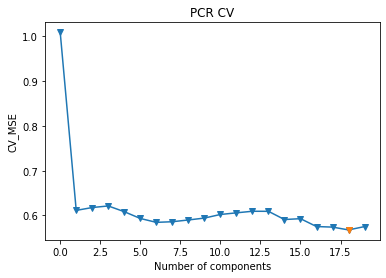

In [32]:
# X_reduced[:, :m] represent the 1st, 2nd, ...(m-1)^th compoenents
for m in range(M):
    score = -model_selection.cross_val_score(reg, X_reduced[:, :m+1], y.ravel(), cv = 10, scoring = 'neg_mean_squared_error').mean()
    PCR_cv_full_mse.append(score)

best_cv_score = min(PCR_cv_full_mse)
best_M = np.where(PCR_cv_full_mse == best_cv_score)[0][0]



print('Best number of components to include:', best_M)
print('Best estimated test MSE: {:0.3f}'.format(best_cv_score))

#plot the cv error

ax = plt.gca()
ax.plot(PCR_cv_full_mse, '-v')
ax.plot(best_M, best_cv_score, marker = 'v')
plt.xlabel('Number of components')
plt.ylabel('CV_MSE')
plt.title('PCR CV')
plt.axis('tight')
plt.show()


## Cross validation for PCR on training data and evaluate on test data

### Cross validation for PCR on training data

In [38]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X,y, test_size = 0.5, random_state = 1)

X_reduced_train = pca.fit_transform(X_train)

CV_train_MSE = []

score1_null = -model_selection.cross_val_score(reg, np.ones((len(X_reduced_train), 1)), y_train.ravel(), cv = 10, scoring = 'neg_mean_squared_error').mean()
CV_train_MSE.append(score1_null)

for m in range(M):
    score = -model_selection.cross_val_score(reg, X_reduced_train[:, :m+1], y_train.ravel(), cv = 10, scoring = 'neg_mean_squared_error').mean()
    CV_train_MSE.append(score)

best_cv_train_score = min(CV_train_MSE)
best_M_train = np.where(CV_train_MSE ==best_cv_train_score)[0][0]


print('Best number of components to include:', best_M_train+1)
print('Best estimated test MSE: {:0.3f}'.format(best_cv_train_score))

Best number of components to include: 7
Best estimated test MSE: 0.639


Note that CV_train_MSE is the estimated test MSE for 0, 1, 2, ...., 19 components.

### Evaluate on test data

In [46]:
X_test_reduced = pca.fit_transform(X_test)[:,:best_M_train]

reg1 = LinearRegression()
reg1.fit(X_reduced_train[:, :best_M_train], y_train)
Test_MSE = mean_squared_error(y_test, reg1.predict(X_test_reduced))

print('MSE for PCR with {} compenents on test data:{:0.3f}'.format(best_M_train+1, Test_MSE))

MSE for PCR with 7 compenents on test data:0.650


### Fit PCR on the full data set

In [42]:
X_reduced[:,:best_M_train]
reg1.fit(X_reduced, y)
print('Standardized coefficient on full data set: ', reg1.coef_)


Standardized coefficient on full data set:  [ 0.23623804 -0.04798004  0.05395603 -0.08214329 -0.12973393  0.13815639
  0.05472085  0.0351534   0.06568825  0.22131205 -0.06687708  0.04662347
  0.16080058 -0.61450135 -0.16472916  0.93884776 -0.77079121 -1.24727188
 -0.18490289]


# Partial Least Square

Best number of components to include:  2
MSE on test data: 0.506


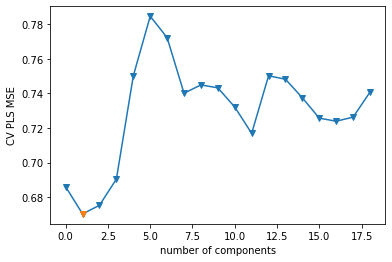

In [48]:
pls_mse = []
for m in range(1,M+1):
    pls = PLSRegression(n_components = m)
    score = -model_selection.cross_val_score(pls, X_train, y_train, cv = 10, scoring = 'neg_mean_squared_error').mean()
    pls_mse.append(score)
pls_best_M = np.where(pls_mse == min(pls_mse))[0][0]

ax = plt.gca()
ax.plot(pls_mse, '-v')
ax.plot(pls_best_M, pls_mse[pls_best_M], marker = 'v')
plt.xlabel('number of components')
plt.ylabel('CV PLS MSE')

pls = PLSRegression(n_components= pls_best_M+1)
pls.fit(X_train, y_train)
pls_test_mse = mean_squared_error(y_test, pls.predict(X_test))

pls_full =  PLSRegression(n_components= pls_best_M+1)
pls_full.fit(X,y)

explained_variance = explained_variance_score(y, pls_full.predict(X))

print('Best number of components to include: ', pls_best_M+1)
print('MSE on test data: {:0.3f}'.format(pls_test_mse))
#print('Standardized coefficient:', pls_full.coef_)